##      **Rick and Morty Character Image Detection**

# Downloading the Dataset
First, we need to install the Kaggle API and authenticate it to download the "Rick and Morty" dataset.

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d mriffaud/rick-and-morty
!unzip rick-and-morty.zip -d rick_and_morty_dataset

Streaming output truncated to the last 5000 lines.
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_173632.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_173840.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_174049.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_174257.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_174466.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_174675.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_174883.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_175092.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_175300.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_175509.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_208041.jpg  
  inflating: rick_and_morty_dataset/rick_and_morty/Morty/2_E6_208250.jpg  
  inflating: rick_and_morty_dataset/rick_and_mort

# Moving the folders to train directory

This code organizes training datasets by moving each folder containing training data to a new directory named 'train'.

In [3]:
import os

base_dir = '/content/rick_and_morty_dataset/rick_and_morty'
train_dir = os.path.join(base_dir, 'train')

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

folders_to_move = ['Beth', 'Jerry', 'Morty', 'Rick', 'Summer']
for folder in folders_to_move:
    src = os.path.join(base_dir, folder)
    dst = os.path.join(train_dir, folder)
    os.rename(src, dst)

# Creating CSV files for train and test dataset :-

we are pre-processing the data and creating train_data.csv and test_data.csv file with columns image_path and label for further processing:-


In [4]:
import os
import pandas as pd

train_dir = '/content/rick_and_morty_dataset/rick_and_morty/train'

image_paths = []
labels = []

for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    if os.path.isdir(label_dir):
        for image_name in os.listdir(label_dir):
            if image_name.endswith('.jpg') or image_name.endswith('.png'):
                image_path = os.path.join(label_dir, image_name)
                image_paths.append(image_path)
                labels.append(label)

data = {'Image_Path': image_paths, 'Label': labels}
df = pd.DataFrame(data)

csv_file_path = '/content/rick_and_morty_dataset/rick_and_morty/train_data.csv'
df.to_csv(csv_file_path, index=False)

print("CSV train file saved successfully!")

CSV train file saved successfully!


In [5]:
import os
import pandas as pd

test_folder = '/content/rick_and_morty_dataset/rick_and_morty/test'

image_paths = []
labels = []

# Iterate through each image file in the test folder
for image_name in os.listdir(test_folder):
    if image_name.endswith('.jpg') or image_name.endswith('.png'):
        image_path = os.path.join(test_folder, image_name)
        image_paths.append(image_path)
        labels.append('Unknown')

df = pd.DataFrame({'Image_Path': image_paths, 'Label': labels})

csv_file_path = '/content/rick_and_morty_dataset/rick_and_morty/test_data.csv'
df.to_csv(csv_file_path, index=False)

print("CSV test file saved successfully!")

CSV test file saved successfully!


# Importing Libraries :-

we need to import machine learning related API's for image processing , manipulating layers and model MobileNetV2 with pre-trained weights , pandas for reading csv files into dataframes and Matplotlib for creating visualizations, such as line plots, bar charts :-

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras import layers, models, optimizers


# Creating Data Generators for Image Classification
This code snippet summarizes the process of creating data generators for training and validation sets . It includes setting up image data augmentation for the training set (train_datagen) and scaling for the testing set (test_datagen), defining the batch size and target image size, and loading the dataset using the flow_from_directory method with categorical class mode for image classification tasks.

In [7]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('/content/rick_and_morty_dataset/rick_and_morty/train_data.csv')

train_df, val_df = train_test_split(df, train_size=0.8, test_size=0.2, random_state=42)

In [8]:
# Define data generators for train and validation sets
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
target_size = (224, 224)

In [9]:

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col='Image_Path',
                                                    y_col='Label',
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                                        x_col='Image_Path',
                                                        y_col='Label',
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 7530 validated image filenames belonging to 5 classes.
Found 1883 validated image filenames belonging to 5 classes.


# Loading the Base-Model
This code snippet defines a MobileNetV2 base model in Keras. The model is configured with an input shape of (224, 224, 3) to match the size and channels of the images in your dataset. It includes all layers of the MobileNetV2 model up to the final fully connected layers but excludes the last fully connected layer, which is often customized for specific tasks.

In [10]:
img_shape = (224, 224, 3)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

9406464/9406464 [==============================] - 0s 0us/step


# Customizing it according to our usecase
This code snippet summarizes the process of creating a custom MobileNetV2-based categorical classification model in Keras. It involves loading the pre-trained MobileNetV2 model, freezing its layers, adding custom layers for classification, compiling the model, shuffling the training data, and training the model. Finally, the trained model is saved as an HDF5 file (MobileNetV2_model_categorical.h5).

In [11]:
from keras import Sequential
from keras.layers import Dense
from keras import optimizers

base_model.trainable = False

model = Sequential([
    base_model,
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 3046469 (11.62 MB)
Trainable params: 788485 (3.01 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [13]:
# Train the model
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10)

model.save('MobileNetV2_model_categorical.h5')

Epoch 1/10
236/236 [==============================] - 655s 3s/step - loss: 0.4402 - accuracy: 0.8416 - val_loss: 0.3313 - val_accuracy: 0.8885
Epoch 2/10
236/236 [==============================] - 621s 3s/step - loss: 0.1864 - accuracy: 0.9359 - val_loss: 0.1570 - val_accuracy: 0.9469
Epoch 3/10
236/236 [==============================] - 588s 2s/step - loss: 0.1225 - accuracy: 0.9582 - val_loss: 0.1176 - val_accuracy: 0.9644
Epoch 4/10
236/236 [==============================] - 590s 2s/step - loss: 0.0857 - accuracy: 0.9704 - val_loss: 0.1587 - val_accuracy: 0.9490
Epoch 5/10
236/236 [==============================] - 628s 3s/step - loss: 0.0732 - accuracy: 0.9741 - val_loss: 0.1428 - val_accuracy: 0.9527
Epoch 6/10
236/236 [==============================] - 628s 3s/step - loss: 0.0588 - accuracy: 0.9795 - val_loss: 0.0974 - val_accuracy: 0.9713
Epoch 7/10
236/236 [==============================] - 560s 2s/step - loss: 0.0473 - accuracy: 0.9835 - val_loss: 0.1626 - val_accuracy: 0.9469

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Plotting the graph:-
This code plots the training and validation loss and accuracy over the epochs. The loss and accuracy values from the history object are used to create line plots. The x-axis represents the epoch number, while the y-axis represents the loss or accuracy. Separate plots are created for training and validation data, and legends are added to differentiate them.

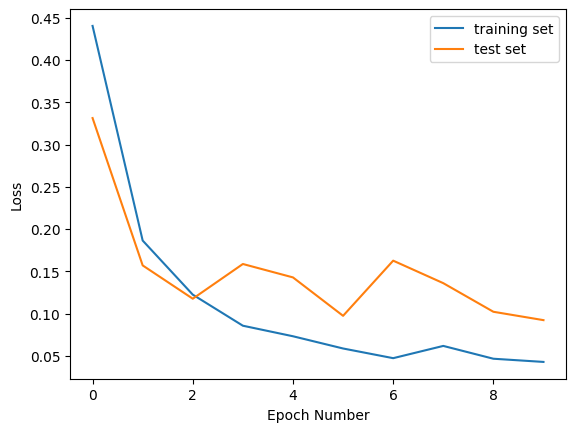

In [14]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

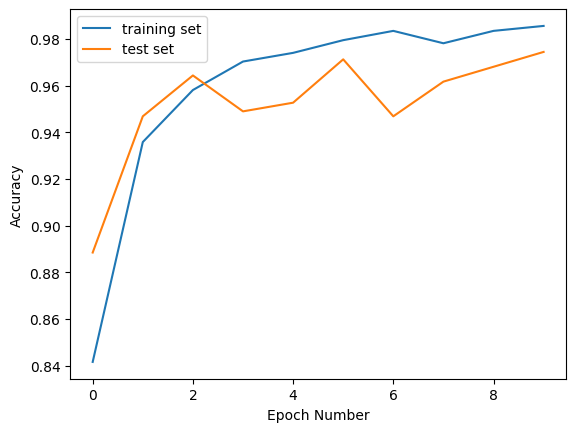

In [15]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

# Testing and labeling unseen data

In [16]:
from tqdm import tqdm
import numpy as np
from keras.utils import load_img , img_to_array


test = pd.read_csv('/content/rick_and_morty_dataset/rick_and_morty/test_data.csv')
test_df = test

test_image = []

for i in tqdm(range(test.shape[0])):
    img = load_img(test['Image_Path'][i], target_size=(224,224,3), grayscale=False)
    img = img_to_array(img)
    img = img/255
    test_image.append(img)

test = np.array(test_image)

prediction_probs = model.predict(test)
prediction = np.argmax(prediction_probs, axis=1)

print(test_df)

100%|██████████| 375/375 [00:06<00:00, 61.16it/s]


12/12 [==============================] - 26s 2s/step
                                            Image_Path    Label
0    /content/rick_and_morty_dataset/rick_and_morty...  Unknown
1    /content/rick_and_morty_dataset/rick_and_morty...  Unknown
2    /content/rick_and_morty_dataset/rick_and_morty...  Unknown
3    /content/rick_and_morty_dataset/rick_and_morty...  Unknown
4    /content/rick_and_morty_dataset/rick_and_morty...  Unknown
..                                                 ...      ...
370  /content/rick_and_morty_dataset/rick_and_morty...  Unknown
371  /content/rick_and_morty_dataset/rick_and_morty...  Unknown
372  /content/rick_and_morty_dataset/rick_and_morty...  Unknown
373  /content/rick_and_morty_dataset/rick_and_morty...  Unknown
374  /content/rick_and_morty_dataset/rick_and_morty...  Unknown

[375 rows x 2 columns]


In [17]:
from sklearn.preprocessing import LabelEncoder
class_indices_inverse = {v: k for k, v in train_generator.class_indices.items()}

prediction = [class_indices_inverse[label] for label in prediction]

predicted_df = pd.DataFrame({
    'Image_Path': test_df['Image_Path'],
    'Label': prediction,
})

csv_path = '/content/rick_and_morty_dataset/rick_and_morty/predicted.csv'

predicted_df.to_csv(csv_path, header=True, index=False)

# image label and prediction and visualization

1/1 [==============================] - 0s 87ms/step


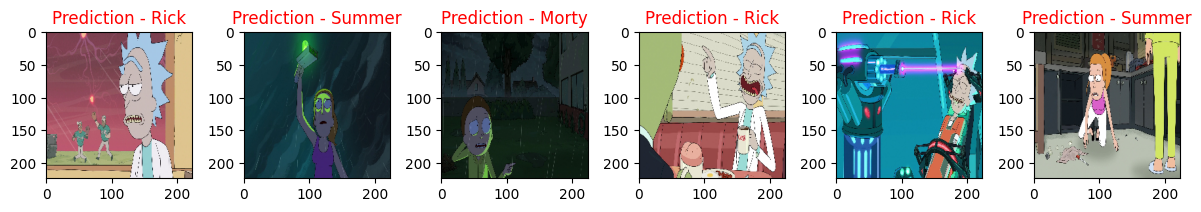

In [24]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_image(filenames, model):
    classes = ["Beth", "Jerry", "Morty", "Rick" , "Summer"]
    num_images = len(filenames)

    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

    for i, filename in enumerate(filenames):
        img_ = image.load_img(filename, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0)
        img_processed /= 255.

        prediction = model.predict(img_processed)
        index = np.argmax(prediction)

        ax = axes[i] if num_images > 1 else axes
        ax.imshow(img_array)
        ax.set_title("Prediction - {}".format(str(classes[index]).title()), size=12, color='red')

    plt.tight_layout()
    plt.show()

# Example usage
filenames = [
    '/content/rick_and_morty_dataset/rick_and_morty/test/3_E1_237237.jpg',
   '/content/rick_and_morty_dataset/rick_and_morty/test/3_E1_391349.jpg',
    '/content/rick_and_morty_dataset/rick_and_morty/test/3_E1_395937.jpg',
    '/content/rick_and_morty_dataset/rick_and_morty/test/3_E1_68527.jpg',
    '/content/rick_and_morty_dataset/rick_and_morty/test/3_E1_74574.jpg',
   '/content/rick_and_morty_dataset/rick_and_morty/test/3_E1_255172.jpg'

]

predict_image(filenames, model)

# importing libraries for classification report , accuracy score and confusion matrix:-

In [19]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved model
model = models.load_model('MobileNetV2_model_categorical.h5')

val_images, val_labels = next(iter(validation_generator))
val_predictions = model.predict(val_images)
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = np.argmax(val_labels, axis=1)


1/1 [==============================] - 2s 2s/step


# f1 score

In [20]:
 # Classification Report
print('Classification Report:')
print(classification_report(val_true_labels, val_pred_labels, zero_division=1))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



# accuracy score

In [25]:
# Accuracy Score
accuracy = accuracy_score(val_true_labels, val_pred_labels)
print('Accuracy Score:', accuracy)

Accuracy Score: 1.0


# confusion matrix

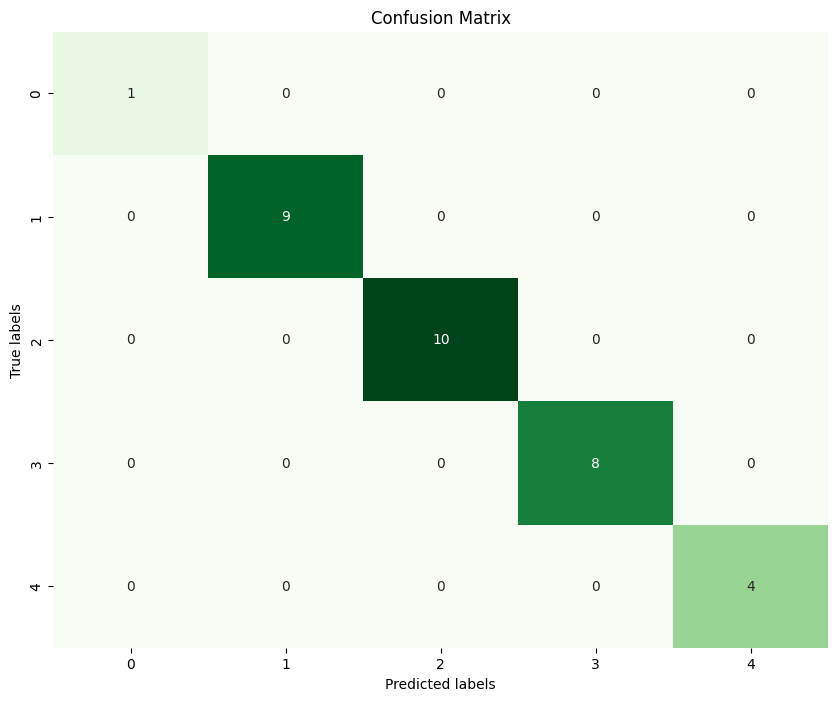

In [ ]:
# Confusion Matrix
cm = confusion_matrix(val_true_labels, val_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()